# Generate Atari Game frames with Generative Adversarial Neural Networks

## References
* [(Lapan, 2020), Deep Reinforcement Learning Hands-On Second Edition](https://www.amazon.com/Deep-Reinforcement-Learning-Hands-optimization/dp/1838826998/ref=sr_1_1?keywords=deep+reinforcement+learning+hands-on&qid=1648904999&sprefix=deep+reinfor%2Caps%2C261&sr=8-1)
    * [Github](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition/blob/master/Chapter03/03_atari_gan.py)
* [(Goodfellow, 2014) Generative adversarial nets](https://arxiv.org/abs/1406.2661?source=post_page-----b665bbae3317----------------------)
* [Simpsons Faces](https://www.kaggle.com/datasets/kostastokis/simpsons-faces)

This notebook depics a GAN architecture to generate simpsons faces.

A GAN architecture contains two different networks competing with each other:
* A Generator $G(z, \theta_g)$, which from random noise can generate fake tensors of the same dimensions of the expected output. In case of images it can be used a Transconvolution, i.e., the inverse of the convolutional process. This network is trained with the aim to fool a *discriminator* making it beleave the fake output is genuine. 
* A Discriminator $D(x, \theta_d)$ that is trained specifically to distinguish between real and fake inputs.

## Requirements
1. Create the conda environment using the provided `environment.yaml` file.
2. Download the dataset from [here](https://www.kaggle.com/datasets/kostastokis/simpsons-faces)

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
from typing import Optional, Tuple
from matplotlib import image as mpl_image
import os
import numpy as np
from skimage.transform import resize

class SimpsonsDataset(Dataset):

    def __init__(
        self, 
        path: str= './simpsons', 
        transform: Optional[callable] = None,
        image_size: Tuple[int] = (64, 64),
        use_cache: bool = True):
        self.path = path
        self.transform = transform
        self.image_size = image_size
        self.files = os.listdir(path)
        self.use_cache = use_cache
        self.cache = {}


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx: int) -> torch.Tensor:
        file = self.files[idx]
        if self.use_cache and file in self.cache:
            return self.cache[file]
        
        example = mpl_image.imread(os.path.join(self.path, file))
        example = resize(example, self.image_size)
        if self.transform is not None:
            example = self.transform(example)
        self.cache[file] = example
        return example
        


In [2]:
from torchvision.transforms import transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

dataset = SimpsonsDataset(transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

### Discriminator $D(x, \theta_d)$
First we define the discriminator. It can be of any architecture, in this case since we are dealing with images, we define a convolutional architecture. What is important is that the output should be binary that signals if the input is true or fake, so the last activation should be a $\mathrm{sigmoid(x)}$.

In [3]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_shape, filters):
        super(Discriminator, self).__init__()
        self.conv_pipe = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=filters, out_channels=filters * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=filters * 2, out_channels=filters * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=filters * 4, out_channels=filters * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=filters * 8, out_channels=1, kernel_size=4, stride=1, padding=0),
            # nn.Sigmoid()
        )

    def forward(self, x):
        conv_out = self.conv_pipe(x)
        return conv_out.view(-1, 1).squeeze(dim=1)

### Generator $G(z, \theta_g)$
The generator can start from a random noise prior $p_g(z)$ and transform it till we obtain a tensor with the same dimensions as the original expected outputs, e.g., images. So we make use of `ConvTranspose` to basically inverse the convolution process.

In [4]:
class Generator(nn.Module):
    def __init__(self, output_shape, latent_vec_size, filters):
        super(Generator, self).__init__()
        self.pipe = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_vec_size, out_channels=filters * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(filters * 8),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=filters * 8, out_channels=filters * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 4),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=filters * 4, out_channels=filters * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters * 2),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=filters * 2, out_channels=filters, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(filters),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=filters, out_channels=output_shape[0], kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.pipe(x)

### Preparations
Below we do several things:
1. Prepare the environments 
2. Define the input shape, which should be dimensions of input images: `C x W x H`. And the `latent_vector_space` which is basically the size of the noise prior to be feed into the generator.
3. Define the Discriminator & Generator networks
4. Define the loss. The training revolves about the discriminator, which output is binary, hence we define a `Binary Cross Entropy Loss`.
5. Define separate optimizers for both networks
6. Define auxiliarly structures.
7. Define labels for the discriminator. The way we train $D$ is by comparing its output testing if its fake or real, so we just need two dummies for that. When we compute the loss of $D$, we always know when we feed a real or fake so we use these dummies to compute the loss.  

In [5]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

device = "cuda" if torch.cuda.is_available() else "cpu"
input_shape = dataset[0].shape
latent_vector_size = 128

net_discriminator = Discriminator(input_shape, filters=64).to(device)
net_generator = Generator(output_shape=input_shape, filters=64, latent_vec_size=latent_vector_size).to(device)

discriminator_loss = nn.BCEWithLogitsLoss()
learing_rate = 2e-4
disc_optimizer = optim.Adam(net_discriminator.parameters(), lr=learing_rate, betas=(0.5, 0.999))
gen_optimizer = optim.Adam(net_generator.parameters(), lr=learing_rate, betas=(0.5, 0.999))

writer = SummaryWriter(log_dir='./tensorboard-simpsons')

gen_losses = []
disc_losses = []

### Training
The training proceeds as follows:
1. Generate a batch from the real games
2. Generate fakes from a random prior
3. **Train Discriminator**: Invoke the discriminator on both, the generated and the real images.
4. The total loss should be the sum of the loss produced by the fakes and the real ones. So the gradient for the discriminator update is: 
$$
\nabla_{\theta_d} \frac{1}{m}\sum_{i=1}^m \begin{bmatrix}
\mathrm{log}D(x^{(i)}) + \mathrm{log}(1 - D(G(z^{(i)})))
\end{bmatrix}
$$
Where $x^{(i)}$ correspond to the $i_{th}$ real $x$ example and similarly $z^{(i)}$ correspond to the $i_{th}$ fake $z$ counterpart.
**IMPORTANT** while computing the discriminator loss for the fakes we need to `detach` the output of the generator to avoid computing gradients for this evaluation, otherwise the training can be messed up.
5. **Train Generator**: Invoke again the discriminator on the fake generated image, this time computing the gradients (no `detach`) and calculate the `BCELoss` against true lables, i.e., we are training to make these images 'real' against the discriminator. So the gradient for the generator update is:
$$
\nabla_{\theta_g} \frac{1}{m}\sum_{i=1}^m \mathrm{log}(1 - D(G(z^{(i)})))
$$

In [6]:
%%time
from tqdm import tqdm
import torchvision.utils as tvutils

anchor_input_v = gen_input_v = torch.normal(0., .5, size=(4, latent_vector_size, 1, 1)).to(device)

epochs = 800
log_img_every = epochs // 50
with tqdm(total=epochs) as progress:
    for iter_no in range(epochs):
        total_dis_loss = 0
        total_gen_loss = 0
        for batch_v in data_loader:
            # 1
            batch_size = batch_v.shape[0]
            true_labels_v = torch.tensor(np.random.uniform(0., 0.3, size=batch_size)).to(device)
            fake_labels_v = torch.tensor(np.random.uniform(0.8, 1.1, size=batch_size)).to(device)
            # 2 input tensor shape: batch x latent vec size x 'width' x 'height' as a single value
            # gen_input_v = torch.FloatTensor(batch_size, latent_vector_size, 1, 1) # pure random
            # gen_input_v.normal_(-0.0446, 0.5704) # now fill with gaussian
            # # from original dataset mu=-0.0446, sigma=0.5704
            gen_input_v = torch.normal(0., .5, size=(batch_size, latent_vector_size, 1, 1)).to(device) # gaussian random
            
            gen_input_v = gen_input_v.to(device)
            batch_v = batch_v.to(device)
            gen_output_v = net_generator(gen_input_v)

            # 3 train discriminator
            disc_optimizer.zero_grad()
            dis_output_true_v = net_discriminator(batch_v)
            dis_output_fake_v = net_discriminator(gen_output_v.detach())
            
            dis_loss = discriminator_loss(dis_output_true_v, true_labels_v) + discriminator_loss(dis_output_fake_v, fake_labels_v)
            dis_loss.backward()
            disc_optimizer.step()
            
            
            total_dis_loss += dis_loss.item()

            # 4 train generator
            gen_optimizer.zero_grad()
            dis_output_v = net_discriminator(gen_output_v)
            gen_loss_v = discriminator_loss(dis_output_v, true_labels_v)
            gen_loss_v.backward()
            gen_optimizer.step()
            
            total_gen_loss += gen_loss_v.item()

        total_dis_loss = total_dis_loss / len(dataset)
        total_gen_loss = total_gen_loss / len(dataset)
        writer.add_scalar('losses/generator', total_gen_loss, global_step=iter_no)
        writer.add_scalar('losses/discriminator', total_dis_loss, global_step=iter_no)
        disc_losses.append(total_dis_loss)
        gen_losses.append(total_gen_loss)

        # log images every n
        if iter_no % log_img_every == 0:
            with torch.no_grad():
                anchor_output = net_generator(anchor_input_v)
                writer.add_image("fake/anchor", tvutils.make_grid(
                    anchor_output.data, normalize=True
                ), global_step=iter_no)

            indices = np.random.randint(0, batch_size, size=16)
            writer.add_image("fake/progress", tvutils.make_grid(
                gen_output_v.data[indices], normalize=True
            ), global_step=iter_no)
            writer.add_image("real", tvutils.make_grid(
                batch_v.data[indices], normalize=True
            ), global_step=iter_no)

        progress.set_postfix({
            'dis_loss': f'{total_dis_loss:.4f}',
            'gen_loss': f'{total_gen_loss:.4f}'
            })
        writer.flush()
        progress.update()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [1:46:35<00:00,  7.99s/it, dis_loss=0.0197, gen_loss=0.0821]

CPU times: user 1h 39min 4s, sys: 5min 49s, total: 1h 44min 54s
Wall time: 1h 46min 35s


Now let's observe the behavior of the losses.

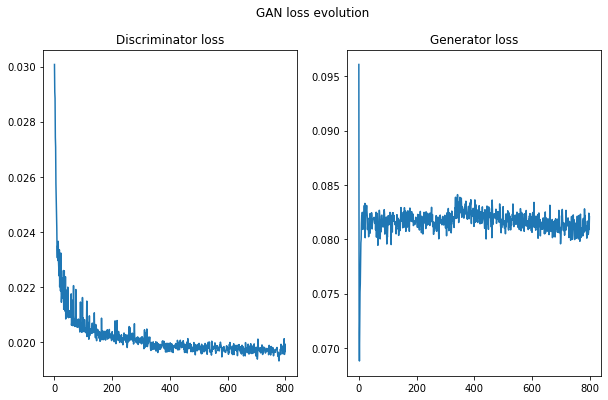

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
plt.suptitle("GAN loss evolution")
ax = axes.ravel()
ax[0].plot(disc_losses)
ax[0].set_title("Discriminator loss")
ax[1].plot(gen_losses)
ax[1].set_title("Generator loss")
plt.show()

We can observe that the losses tend to be inverse to each other. Whenever the discriminator loss tends to zero, means the discriminator is successfully able to discern fakes vs real images, and when the generator loss decreases, it means the discrimenator generates 'credible' images that the discriminator has a harder time to label as fake (hence its loss increases).

Now let's observe the results

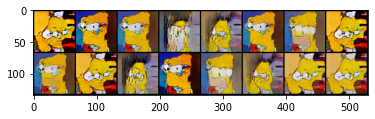

In [8]:
net_generator.eval()
with torch.no_grad():
    gen_input_v = torch.normal(0., 1., size=(16, latent_vector_size, 1, 1)).to(device)
    gen_output_v = net_generator(gen_input_v)
    generated_images = tvutils.make_grid(gen_output_v.data, normalize=True).cpu().numpy()
    generated_images = np.transpose(generated_images, [1, 2, 0])
    plt.imshow(generated_images)
    plt.show()

Not perfect, but some improvement starts to show at iteration 500

In [9]:
torch.save(net_discriminator.state_dict(), './checkpoints/simpsons-discriminator-v2.cpt')
torch.save(net_generator.state_dict(), './checkpoints/simpsons-generator-v2.cpt')